# **C.O.L.L.A.B.**
<hr style="border:2px solid black">

## Goal: 
* Create an interactive dashbard to assist families with moving
* Create and implement additional features like violent crime rate, commute time, and internet accessibility
<hr style="border:2px solid black">

# Imports

In [39]:
import pandas as pd
import numpy as np
from wrangle_2 import wrangle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import sklearn
import random
from itertools import product
import explore as ex
random.seed(42)
np.random.seed(42)
from scipy import stats
from scipy.stats import zscore

<hr style="border:2px solid black">

# **Acquire**
Plan --> **Acquire** --> Prepare --> Explore --> Model --> Deliver

* Economic Policy Institute Family Budget Calculator (Cost estimates for by family size and MSA)
* US Census Bureau - (Commute times, Household Income by Gender and Family Composition)
* Federal Bureau of Investigation (Crime Rates)

<hr style="border:2px solid black">

# **Prepare**

**Prepare Actions:**
* Merge census dataframes family_income and family_count on MSA
* To better estimate family income based on family composition, use the estimates of family count by family type(Married, Single Male with kids, Single Male without kids, Single Female with kids, Single Female without kids) and the estimates of income by family type. e.g. (female_with_kids (income) * female_with_kids (count) + (male_with_kids (income) * male_with_kids (count)))/(total_count)
* Adjust for inflation 2020 to 2022
* Merge census dataframe (family) on to the cost_of_living dataframe (col) on MSA.
* Estimate an average commute time for each MSA by multiplying the count of commuters by the midpoint of the range and dividing by the total number of commuters.
* Transform the values of the msa column in epi, census, and fbi datasets to standard format for merging.
* Merge epi, census, and fbi datasets.

In [40]:
cost, epi_census, fbi, intern, commute, pop = wrangle()

<hr style="border:2px solid black">

# **Clustering**
Plan --> Acquire --> Prepare --> Explore --> **Model** --> Deliver


In [41]:
def scale_columns(df, scaler=MinMaxScaler()):
        '''
    Scales the numeric columns of a DataFrame.

    This function takes a DataFrame and a scaler (default is MinMaxScaler), 
    scales the numeric columns that are not 'msa', and adds the scaled values 
    as new columns to the DataFrame. The new columns have the same names as the 
    original columns, but with '_scaled' appended.

    Parameters:
    df (pandas.DataFrame): The DataFrame to scale.
    scaler (sklearn.preprocessing): The scaler to use. Default is MinMaxScaler.

    Returns:
    df (pandas.DataFrame): The DataFrame with the scaled columns added.
        '''
    
        scaled_columns = df[df.columns.difference(['msa'])]
        scaled_values = scaler.fit_transform(scaled_columns)
        for col, values in zip(scaled_columns.columns, scaled_values.T):
            df[f'{col}_scaled'] = values
        return df

In [42]:
cost = scale_columns(cost, scaler=MinMaxScaler())

In [43]:
def add_clusters(df, features, n_clusters=3, column_name='cluster', cluster_algo=KMeans(random_state=42), plot=False):
    """
    Adds a new column to a DataFrame with cluster labels and optionally plots the clusters.

    This function takes a DataFrame, a list of features, and the number of clusters, 
    fits a clustering algorithm on the features, and adds the clusters as a new column 
    to the DataFrame. The name of the new column is specified by the 'column_name' parameter.
    If 'plot' is True, it also plots the clusters on the features.

    Parameters:
    df (pandas.DataFrame): The DataFrame to add clusters to.
    features (list): The features to use for clustering.
    n_clusters (int, optional): The number of clusters. Default is 3.
    column_name (str, optional): The name of the new column. Default is 'cluster'.
    cluster_algo (sklearn.cluster, optional): The clustering algorithm to use. Default is KMeans.
    plot (bool, optional): Whether to plot the clusters. Default is False.

    Returns:
    df (pandas.DataFrame): The DataFrame with the new column added.
    """
    # Select the features to cluster
    X = df[features]

    # Fit the clustering algorithm and predict the clusters
    cluster_algo.set_params(n_clusters=n_clusters)
    clusters = cluster_algo.fit_predict(X)

    # Add the clusters to the original dataframe
    df[column_name] = clusters

    if plot:
        # Plot the clusters on the features
        pairplot = sns.pairplot(data=df, vars=['affordability_ratio', 'violent_crime', 'property_crime', 'est_commute','highschool_grad_rate'], hue=column_name, palette='RdYlGn')
        pairplot.fig.suptitle(column_name, y=1.02)  # y=1.02 raises the title slightly
        plt.show()

    return df

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


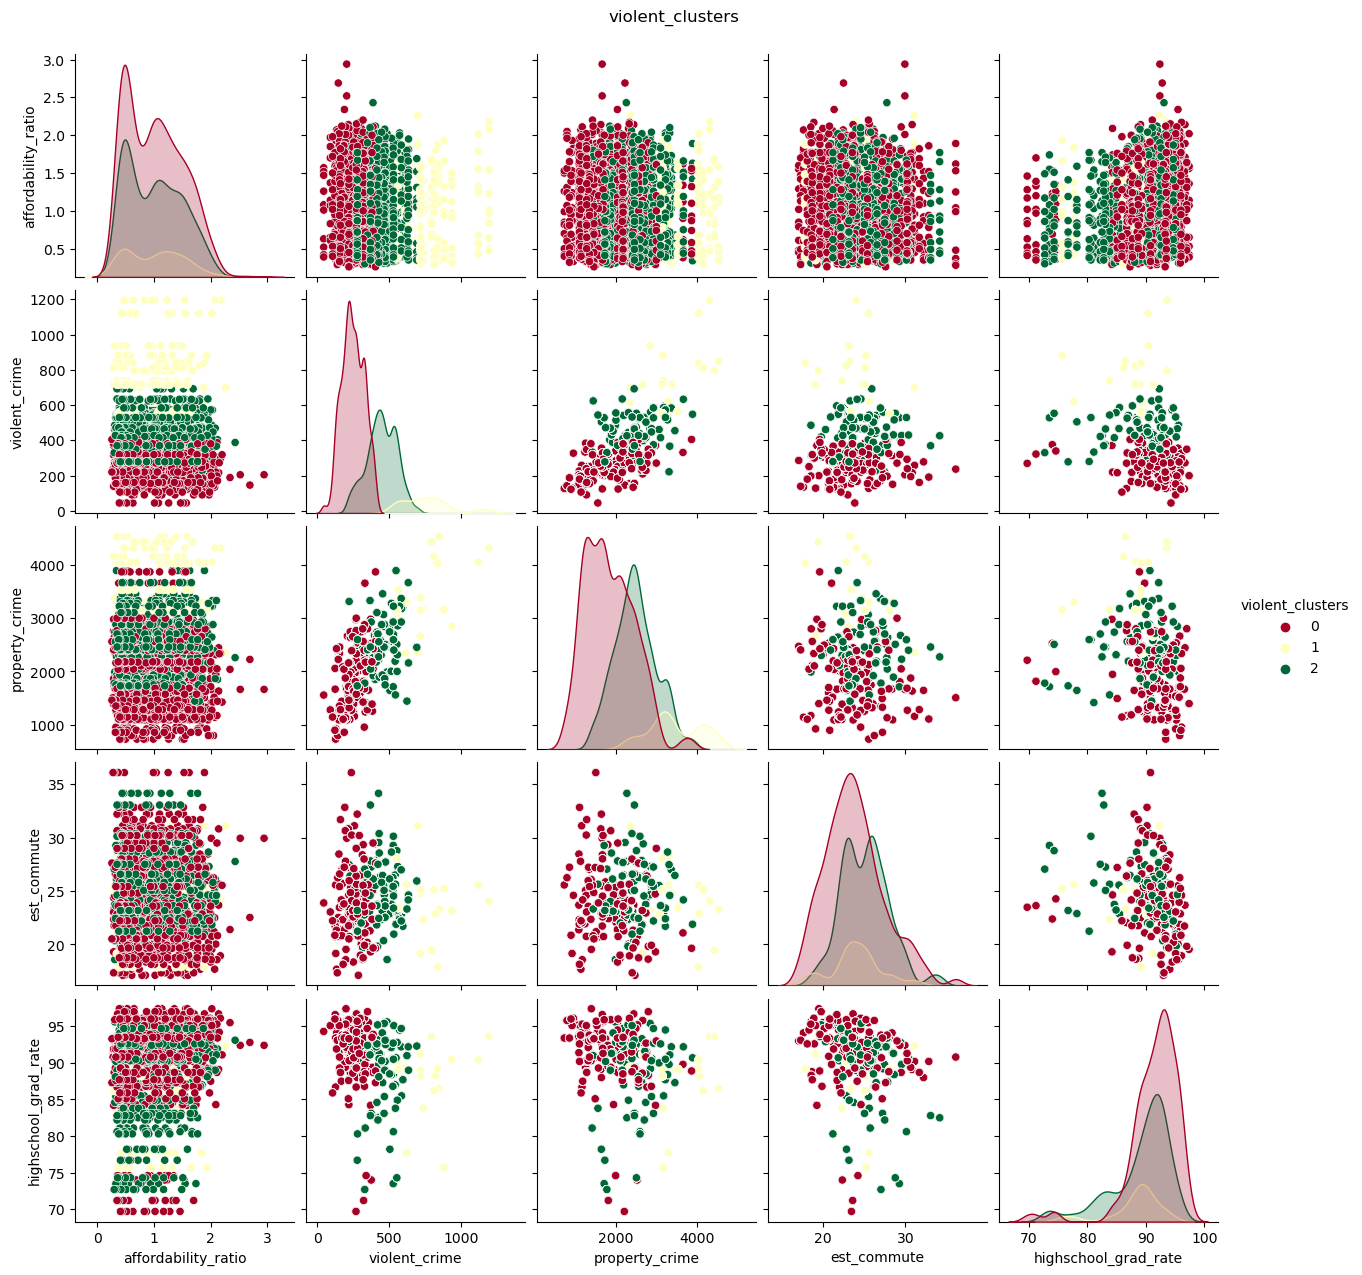

In [44]:
# cluster on the violent crime features and plot the clusters
cost = add_clusters(cost, ['murder_and_nonnegligent_manslaughter_scaled', 'rape_scaled', 'robbery_scaled',
       'aggravated_assault_scaled'], n_clusters=3, column_name='violent_clusters', plot=True)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


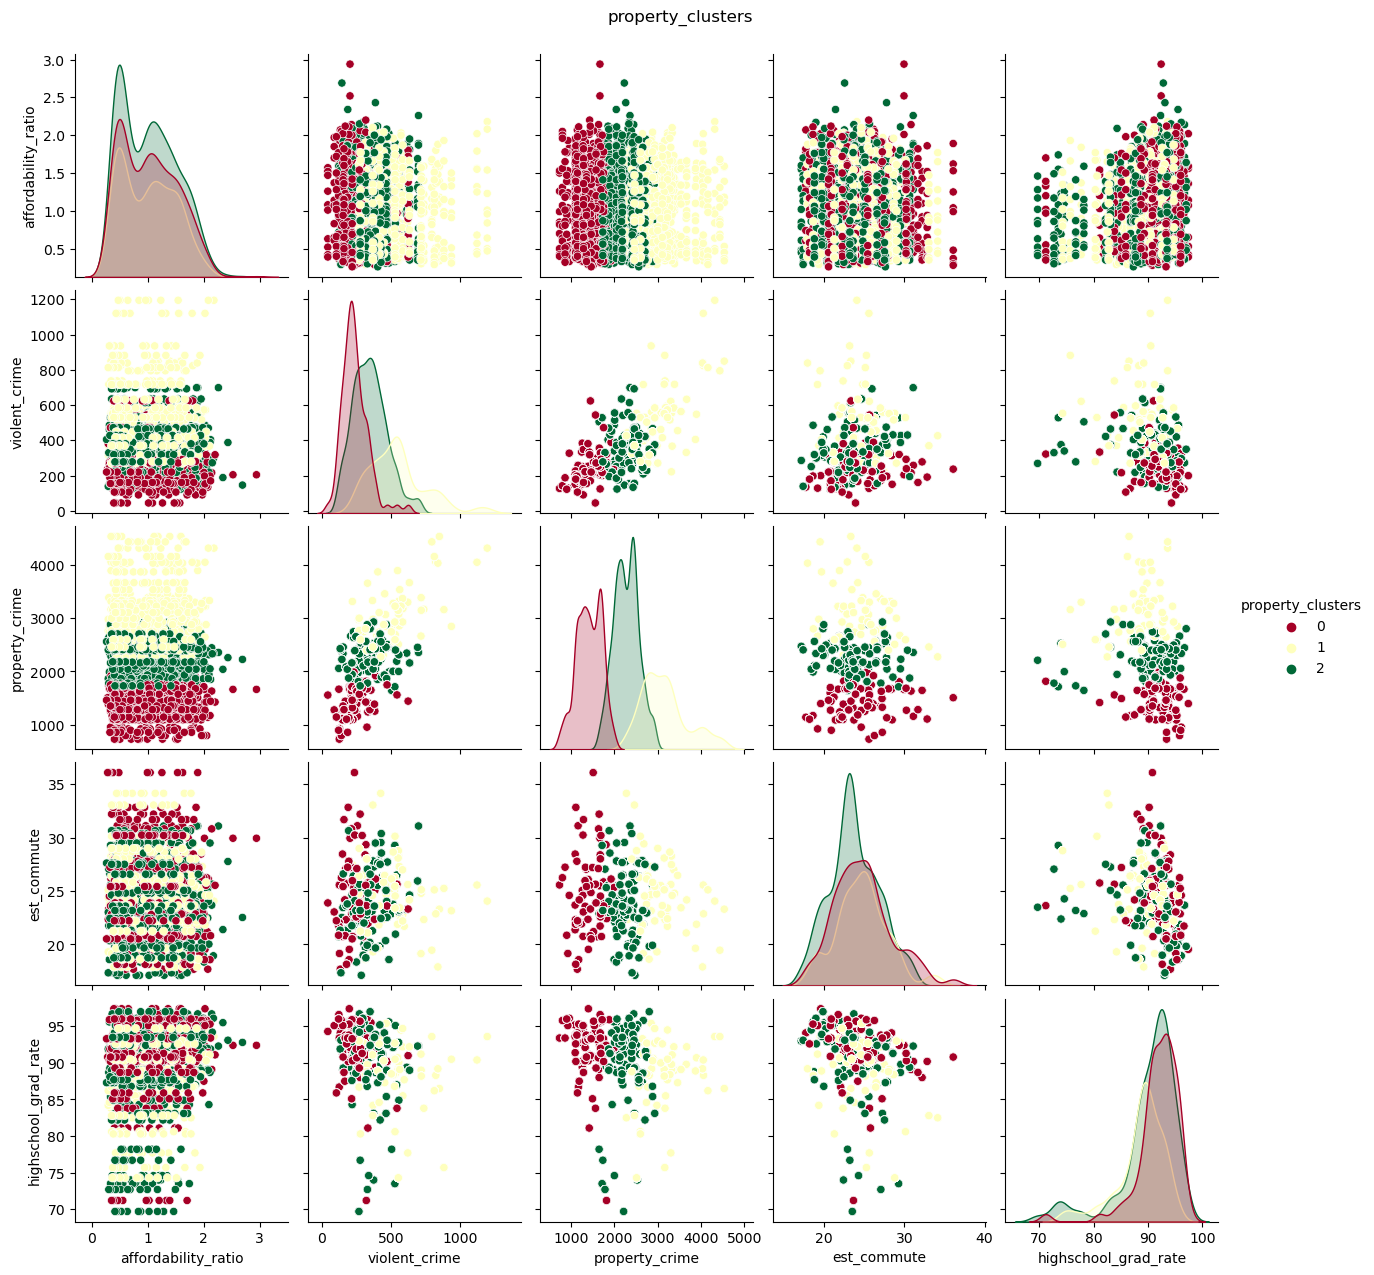

In [45]:
# cluster on the property crime features and plot the clusters
cost = add_clusters(cost, ['burglary_scaled', 'larceny_theft_scaled',
       'motor_vehicle_theft_scaled'], n_clusters=3, column_name='property_clusters', plot=True)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


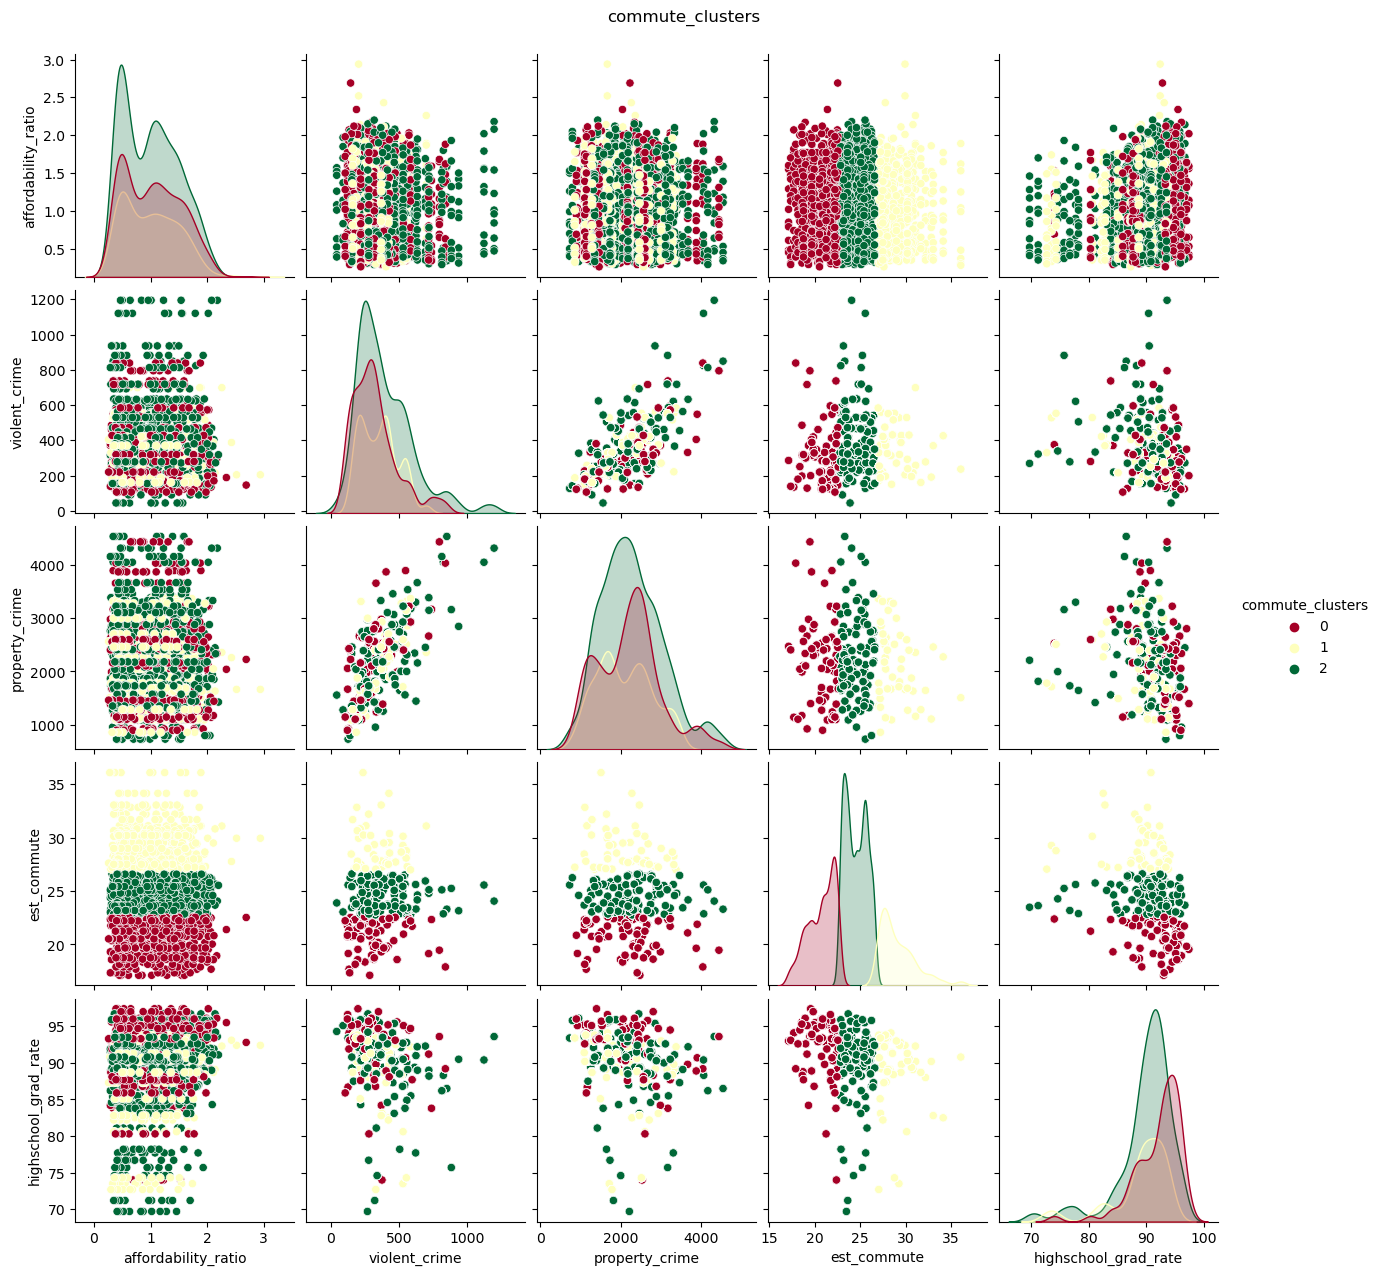

In [46]:
# cluster on the estimated commute and plot the clusters
cost = add_clusters(cost, ['est_commute'], n_clusters=3, column_name='commute_clusters', plot=True)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


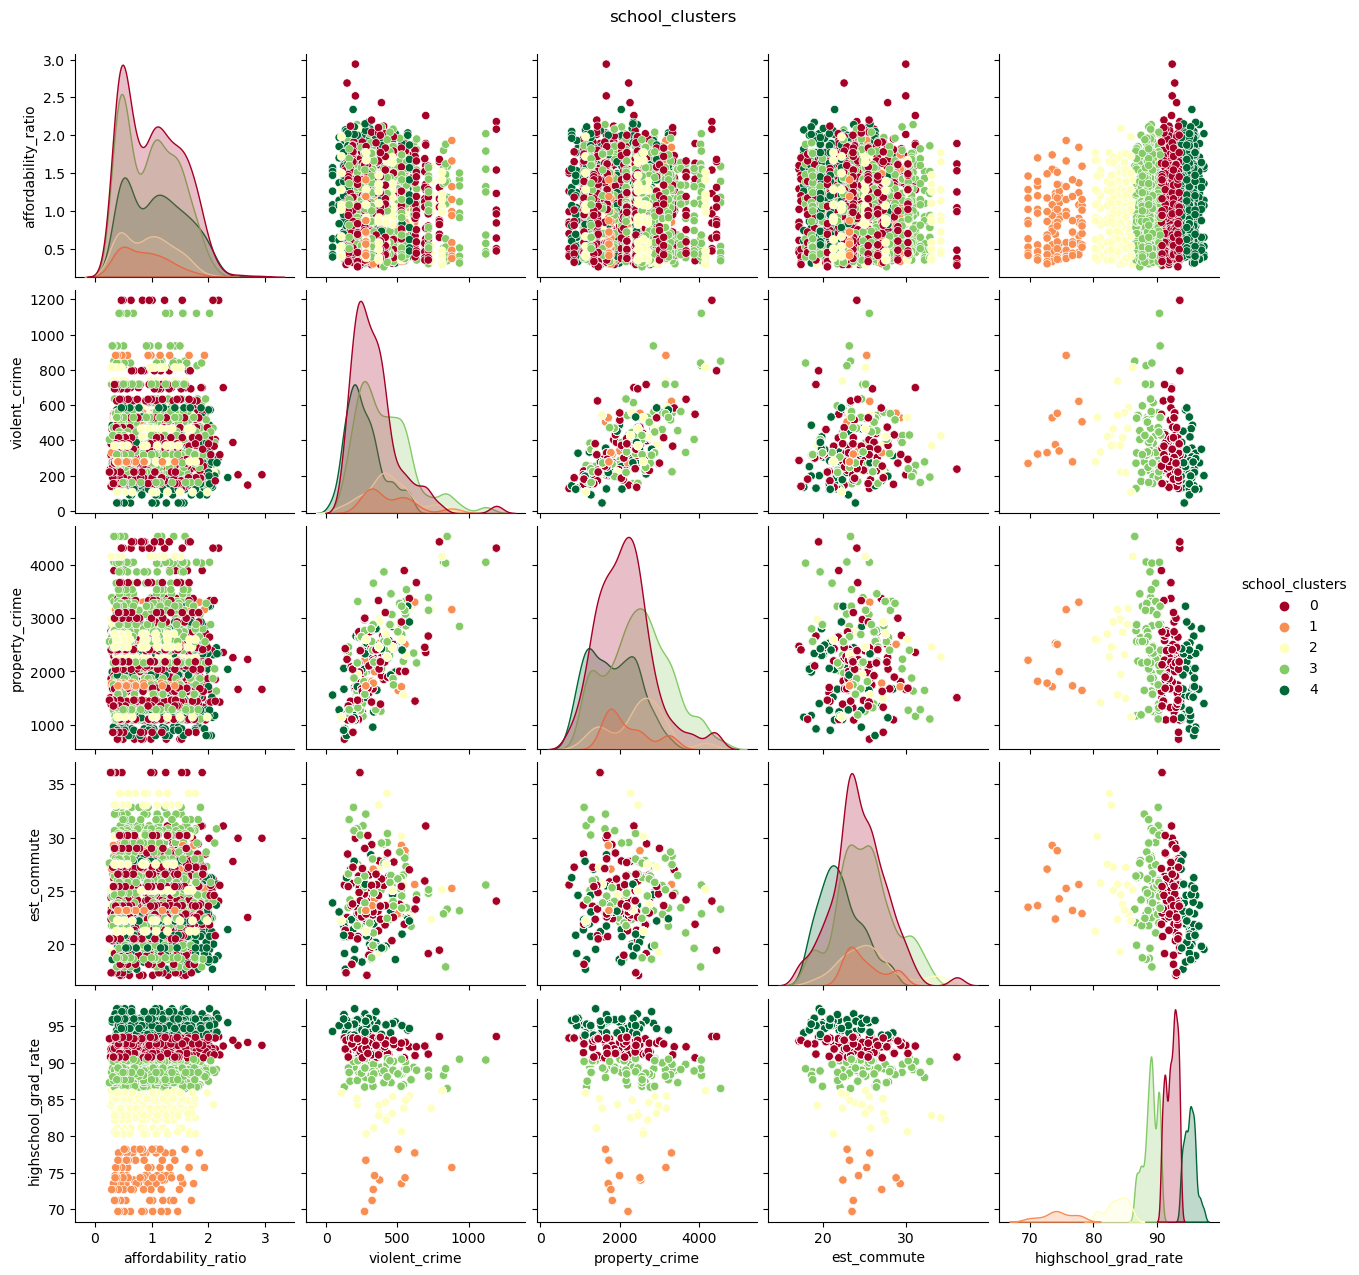

In [47]:
# cluster on the High School Graduation and plot the clusters
cost = add_clusters(cost, ['highschool_grad_rate'], n_clusters=5, column_name='school_clusters', plot=True)

In [48]:
# map clusters
cost['violent_clusters'] = cost['violent_clusters'].map({0: 'Low', 1: 'High', 2: 'Med'})
cost['property_clusters'] = cost['property_clusters'].map({0: 'Low', 1: 'High', 2: 'Med'})
cost['commute_clusters'] = cost['commute_clusters'].map({0: 'Low', 1: 'High', 2: 'Avg'})
cost['school_clusters'] = cost['school_clusters'].map({0: 'High', 1: 'Lowest', 2: 'Low', 3: 'Avg', 4: 'Highest'})

In [49]:
# write the cost dataframe to a csv for tableau dashboard
cost.to_csv('tableau_col.csv')

<hr style="border:2px solid black">

# **Explore**
Plan --> Acquire --> Prepare --> **Explore** --> Model --> Deliver

> ## `Violent Clusters`:
 ### <u>Does the Low cluster have a significantly lower mean violent_crime rate than the population?</u>

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**I will now use a 1 sample, 1 tail, T-test to investigate whether the mean violent_crime rate for the Low cluster is significantly less than the mean violent_crime rate for the population.**

* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: Mean of violent_crime of Low => Mean of violent_crime of all MSAs.**<br>
**Ha: Mean of violent_crime of Low < Mean of violent_crime of all MSAs.**
</div>

In [50]:
alpha = 0.5
# cluster sample
low_crime = cost[cost['violent_clusters'] == 'Low'].violent_crime
# population mean
pop_mean = cost.violent_crime.mean()

t, p = stats.ttest_1samp(low_crime, pop_mean)

print(t, p/2, alpha)

if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t > 0:
    print("We fail to reject null hypothesis.")
else:
    print("We reject the null hypothesis.")

-53.88218305519122 0.0 0.5
We reject the null hypothesis.


 ### <u>Does the High cluster have a significantly higher mean violent_crime rate than the population?</u>

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**I will now use a 1 sample, 1 tail, T-test to investigate whether the mean violent_crime rate for the High cluster is significantly more than the mean violent_crime rate for the population.**

* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: Mean of violent_crime of High <= Mean of violent_crime of all MSAs.**<br>
**Ha: Mean of violent_crime of High > Mean of violent_crime of all MSAs.**
</div>

In [51]:
alpha = 0.5
# cluster sample
high_crime = cost[cost['violent_clusters'] == 'High'].violent_crime
# population mean
pop_mean = cost.violent_crime.mean()

t, p = stats.ttest_1samp(high_crime, pop_mean)

print(t, p/2, alpha)

if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t < 0:
    print("We fail to reject null hypothesis.")
else:
    print("We reject the null hypothesis.")

32.73046950087789 2.4282689335805002e-82 0.5
We reject the null hypothesis.


> ## `Property Clusters`:

### <u>Does the Low cluster have a significantly lower mean property_crime than the population?</u>

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**I will now use a 1 sample, 1 tail, T-test to investigate whether the mean property_crime rate for the Low cluster is significantly less than the mean property_crime rate for the population.**

* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: Mean of property_crime of Low => Mean of property_crime of all MSAs.**<br>
**Ha: Mean of property_crime of Low < Mean of property_crime of all MSAs.**
</div>

In [52]:
alpha = 0.5
# cluster sample
low_crime = cost[cost['property_clusters'] == 'Low'].property_crime
# population mean
pop_mean = cost.property_crime.mean()

t, p = stats.ttest_1samp(low_crime, pop_mean)

print(t, p/2, alpha)

if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t > 0:
    print("We fail to reject null hypothesis.")
else:
    print("We reject the null hypothesis.")

-78.32717882932216 0.0 0.5
We reject the null hypothesis.


### <u>Does the High cluster have a significantly higher mean property_crime than the population?</u>

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**I will now use a 1 sample, 1 tail, T-test to investigate whether the mean property_crime rate for the High cluster is significantly higher than the mean property_crime rate for the population.**

* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: Mean of property_crime of High <= Mean of property_crime of all MSAs.**<br>
**Ha: Mean of property_crime of High > Mean of property_crime of all MSAs.**
</div>

In [53]:
alpha = 0.5
# cluster sample
high_crime = cost[cost['property_clusters'] == 'High'].property_crime
# population mean
pop_mean = cost.property_crime.mean()

t, p = stats.ttest_1samp(high_crime, pop_mean)

print(t, p/2, alpha)

if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t < 0:
    print("We fail to reject null hypothesis.")
else:
    print("We reject the null hypothesis.")

42.72177532456486 7.096462632035699e-183 0.5
We reject the null hypothesis.


> ## `Commute Clusters`:

### <u>Does the Low cluster have a significantly lower mean commute than the population?</u>

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**I will now use a 1 sample, 1 tail, T-test to investigate whether the mean commute for the Low cluster is significantly less than the mean commute for the population.**

* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: Mean of commute of Low => Mean of commute of all MSAs.**<br>
**Ha: Mean of commute of Low < Mean of commute of all MSAs.**
</div>

In [54]:
alpha = 0.5
# cluster sample
low_commute = cost[cost['commute_clusters'] == 'Low'].est_commute
# population mean
pop_mean = cost.est_commute.mean()

t, p = stats.ttest_1samp(low_commute, pop_mean)

print(t, p/2, alpha)

if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t > 0:
    print("We fail to reject null hypothesis.")
else:
    print("We reject the null hypothesis.")

-64.62979345079752 1.069402093451693e-299 0.5
We reject the null hypothesis.


> ### <u>Does the High cluster have a significantly higher mean commute than the population?</u>

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**I will now use a 1 sample, 1 tail, T-test to investigate whether the mean commute for the High cluster is significantly higher than the mean commute for the population.**

* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: Mean of commute of High <= Mean of commute of all MSAs.**<br>
**Ha: Mean of commute of High > Mean of commute of all MSAs.**
</div>

In [55]:
alpha = 0.5
# cluster sample
high_commute = cost[cost['commute_clusters'] == 'High'].est_commute
# population mean
pop_mean = cost.est_commute.mean()

t, p = stats.ttest_1samp(high_crime, pop_mean)

print(t, p/2, alpha)

if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t < 0:
    print("We fail to reject null hypothesis.")
else:
    print("We reject the null hypothesis.")

142.12714485962266 0.0 0.5
We reject the null hypothesis.


> ## `School Clusters`:

### <u>Does the Lowest cluster have a significantly lower mean highschool_grad_rate than the population?</u>

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**I will now use a 1 sample, 1 tail, T-test to investigate whether the mean highschool_grad_rate for the Lowest cluster is significantly lower than the mean highschool_grad_rate rate for the population.**

* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: Mean of highschool_grad_rate of Lowest => Mean of highschool_grad_rate of all MSAs.**<br>
**Ha: Mean of highschool_grad_rate of Lowest < Mean of highschool_grad_rate of all MSAs.**
</div>

In [56]:
alpha = 0.5
# cluster sample
lowest_grad = cost[cost['school_clusters'] == 'Lowest'].highschool_grad_rate
# population mean
pop_mean = cost.highschool_grad_rate.mean()

t, p = stats.ttest_1samp(lowest_grad, pop_mean)

print(t, p/2, alpha)

if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t > 0:
    print("We fail to reject null hypothesis.")
else:
    print("We reject the null hypothesis.")

-66.46650639830538 2.429591334809605e-90 0.5
We reject the null hypothesis.


### <u>Does the Highest cluster have a significantly higher mean highschool_grad_rate than the population?</u>

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

**I will now use a 1 sample, 1 tail, T-test to investigate whether the mean highschool_grad_rate for the Highest cluster is significantly higher than the mean highschool_grad_rate rate for the population.**

* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: Mean of highschool_grad_rate of Highest <= Mean of highschool_grad_rate of all MSAs.**<br>
**Ha: Mean of highschool_grad_rate of Highest > Mean of highschool_grad_rate of all MSAs.**
</div>

In [57]:
alpha = 0.5
# cluster sample
highest_grad = cost[cost['school_clusters'] == 'Highest'].highschool_grad_rate
# population mean
pop_mean = cost.highschool_grad_rate.mean()

t, p = stats.ttest_1samp(highest_grad, pop_mean)

print(t, p/2, alpha)

if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t < 0:
    print("We fail to reject null hypothesis.")
else:
    print("We reject the null hypothesis.")

119.82096623992068 0.0 0.5
We reject the null hypothesis.


<hr style="border:2px solid black">

# **Conclusions**


### <u>Recommendations:</u>
>* Affordability is extremely important, but considering outside factors can help shape the ideal community for you.
>* Families should keep an open mind when looking at ideal places to move to. (Maybe what's best for your family is somewhere you never imagined yourself living)

### <u>Next Steps:</u>
>* Find additional dataframes to continue adding possible features for families to select
>* Take analysis to county level for increased granularity
>* Develop dashboard into website or app for easier access